# Celebrity Look Alike - Deep Learning Project

Dataset - Celebrity Faces.

Source - Kaggle

In [ ]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pathlib import Path
import os.path
import random
import os
import zipfile
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda, Flatten, Activation, Conv2D, MaxPooling2D, Reshape, Concatenate, UpSampling2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.utils import img_to_array, load_img
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image


import cv2
import csv


In [ ]:
# Helper Functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-08-31 16:47:50--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-31 16:47:50 (97.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Extracting/Unzipping files
local_zip = "drive/MyDrive/Colab Notebooks/train.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall("drive/MyDrive/Colab Notebooks/train_data")

zip_ref.close()

In [ ]:
local_zip_ = "drive/MyDrive/Colab Notebooks/test.zip"
zip_ref_ = zipfile.ZipFile(local_zip_, 'r')
zip_ref_.extractall("drive/MyDrive/Colab Notebooks/test_data")

zip_ref_.close()

In [ ]:
dataset_path_tr = "//content/drive/MyDrive/Colab Notebooks/train_data/train"
walk_through_dir(dataset_path_tr);

There are 151 directories and 1 images in '//content/drive/MyDrive/Colab Notebooks/train_data/train'.
There are 0 directories and 30 images in '//content/drive/MyDrive/Colab Notebooks/train_data/train/Madhuri Dixit'.
There are 0 directories and 27 images in '//content/drive/MyDrive/Colab Notebooks/train_data/train/Lara Dutta'.
There are 0 directories and 154 images in '//content/drive/MyDrive/Colab Notebooks/train_data/train/Rebecca Ferguson'.
There are 0 directories and 112 images in '//content/drive/MyDrive/Colab Notebooks/train_data/train/Zendaya'.
There are 0 directories and 19 images in '//content/drive/MyDrive/Colab Notebooks/train_data/train/Kim Jennie'.
There are 0 directories and 55 images in '//content/drive/MyDrive/Colab Notebooks/train_data/train/Lionel Messi'.
There are 0 directories and 156 images in '//content/drive/MyDrive/Colab Notebooks/train_data/train/Elliot page'.
There are 0 directories and 147 images in '//content/drive/MyDrive/Colab Notebooks/train_data/train/He

In [ ]:
dataset_path_te = "//content/drive/MyDrive/Colab Notebooks/test_data/test"
walk_through_dir(dataset_path_te);

There are 151 directories and 1 images in '//content/drive/MyDrive/Colab Notebooks/test_data/test'.
There are 0 directories and 22 images in '//content/drive/MyDrive/Colab Notebooks/test_data/test/Madhuri Dixit'.
There are 0 directories and 25 images in '//content/drive/MyDrive/Colab Notebooks/test_data/test/Lara Dutta'.
There are 0 directories and 26 images in '//content/drive/MyDrive/Colab Notebooks/test_data/test/Rebecca Ferguson'.
There are 0 directories and 28 images in '//content/drive/MyDrive/Colab Notebooks/test_data/test/Zendaya'.
There are 0 directories and 12 images in '//content/drive/MyDrive/Colab Notebooks/test_data/test/Kim Jennie'.
There are 0 directories and 33 images in '//content/drive/MyDrive/Colab Notebooks/test_data/test/Lionel Messi'.
There are 0 directories and 34 images in '//content/drive/MyDrive/Colab Notebooks/test_data/test/Elliot page'.
There are 0 directories and 50 images in '//content/drive/MyDrive/Colab Notebooks/test_data/test/Henry Cavil'.
There are 

In [ ]:
#Placing Data in Dataframes

#TRAIN
image_dir_train = Path(dataset_path_tr)
filepaths_train = list(image_dir_train.glob(r'**/*.JPG')) + list(image_dir_train.glob(r'**/*.jpg')) + list(image_dir_train.glob(r'**/*.png')) + list(image_dir_train.glob(r'**/*.png'))
labels_train = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths_train))
filepaths_train = pd.Series(filepaths_train, name="Filepath_train").astype(str)
labels_train = pd.Series(labels_train, name="Labels_train")

train_dataset_df = pd.concat([filepaths_train, labels_train], axis=1)

#TEST
image_dir_test = Path(dataset_path_te)
filepaths_test = list(image_dir_test.glob(r'**/*.JPG')) + list(image_dir_test.glob(r'**/*.jpg')) + list(image_dir_test.glob(r'**/*.png')) + list(image_dir_test.glob(r'**/*.png'))
labels_test = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths_test))
filepaths_test = pd.Series(filepaths_test, name="Filepath_test").astype(str)
labels_test = pd.Series(labels_test, name="Labels_test")

test_dataset_df = pd.concat([filepaths_test, labels_test], axis=1)


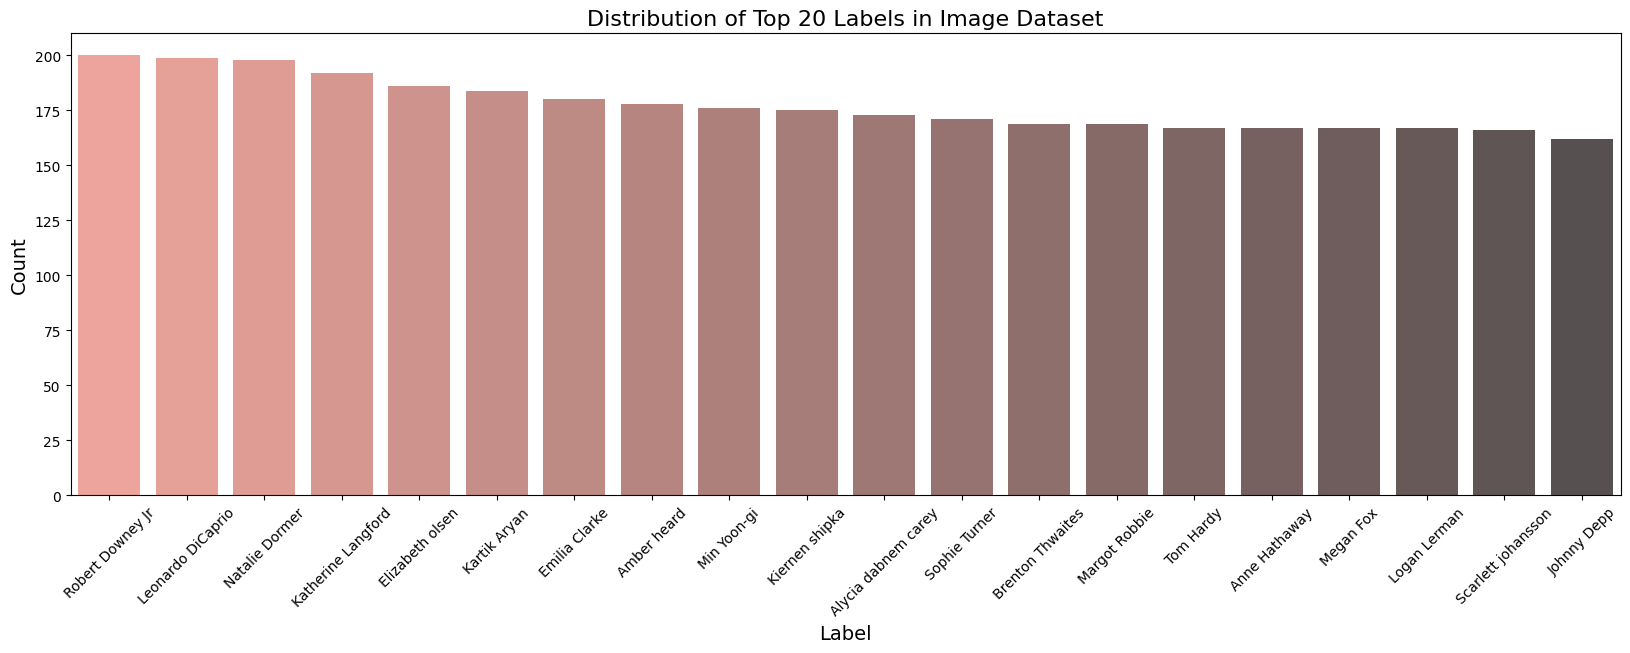

In [ ]:
# Top Train 20 Labels

label_counts = train_dataset_df['Labels_train'].value_counts()[:20]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Top 20 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

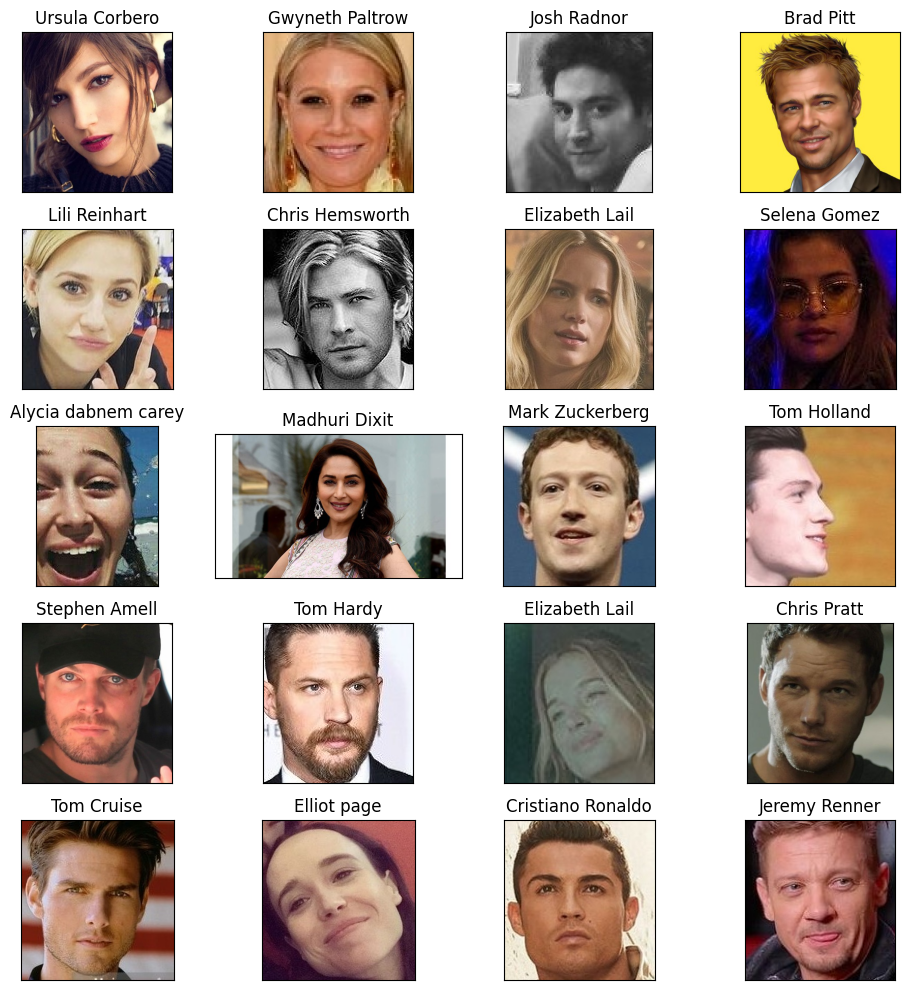

In [ ]:
# Displaying 20 training images with their labels
from PIL import Image

random_index = np.random.randint(0, len(train_dataset_df), 20)
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_dataset_df.Filepath_train[random_index[i]]))
    ax.set_title(train_dataset_df.Labels_train[random_index[i]])
plt.tight_layout()
plt.show()

#### Computer Error Rate Analysis

In [ ]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

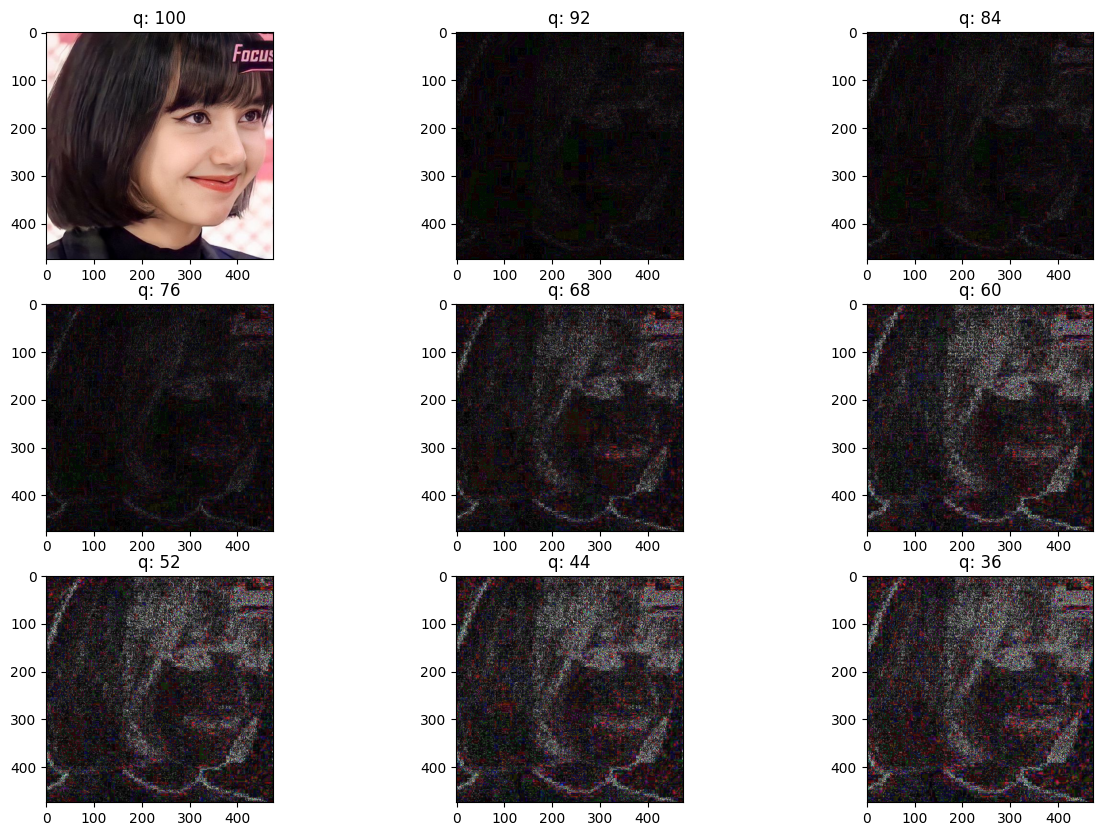

In [ ]:
# View random sample from the Train dataset
p = random_sample('//content/drive/MyDrive/Colab Notebooks/train_data/train/Lisa')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

#### Data Preprocessing

In [ ]:
train_generator = ImageDataGenerator(rescale = 1./255.,
                                     preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
                                     validation_split=0.20
)


test_generator = ImageDataGenerator(rescale = 1./255.,
                                    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [ ]:
TARGET_SIZE = (224,224)
BATCH_SIZE = 32

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_dataset_df,
    x_col='Filepath_train',
    y_col='Labels_train',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_dataset_df,
    x_col='Filepath_train',
    y_col='Labels_train',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_dataset_df,
    x_col='Filepath_test',
    y_col='Labels_test',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 12541 validated image filenames belonging to 151 classes.
Found 3135 validated image filenames belonging to 151 classes.
Found 4635 validated image filenames belonging to 151 classes.


Found 12541 validated image filenames belonging to 151 classes.

Found 3135 validated image filenames belonging to 151 classes.

Found 4635 validated image filenames belonging to 151 classes.

In [ ]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

### Prior and KL regularizer

In [ ]:
## Getting PRIOR

def get_prior(num_modes, latent_dim):
  prior = tfd.MixtureSameFamily(mixture_distribution = tfd.Categorical(probs=tf.divide(tf.ones([num_modes,]), num_modes)),
                                components_distribution = tfd.MultivariateNormalDiag(loc = tf.Variable(tf.random.normal([num_modes, latent_dim]), trainable=True, dtype=tf.float32),
                                                                                      scale_diag = tfp.util.TransformedVariable(initial_value = tf.ones([num_modes, latent_dim]),
                                                                                                                                bijector = tfb.Softplus())))
  return prior

In [ ]:
prior = get_prior(num_modes=2, latent_dim=50)

In [ ]:
## Get KL regularizer

def get_kl_regularizer(prior_distribution):

    return tfpl.KLDivergenceRegularizer(distribution_b=prior_distribution,
                                        use_exact_kl=False,
                                        weight=1.0,
                                        test_points_fn=lambda q: q.sample(3),
                                        test_points_reduce_axis = (0,1))

kl_regularizer = get_kl_regularizer(prior)

### Creating the Model

#### Inception V3 Pretrained Model

In [ ]:
len(train_images)

392

In [ ]:
inception = InceptionV3(weights='imagenet', include_top=False)

inputs = inception.input
x = augment(inputs)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(151, kernel_regularizer=regularizers.l2(0.005),activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=SGD(lr=0.0001,
                            momentum=0.9),
              loss='categorical_crossentropy' ,
              metrics=['accuracy'])

# Callbacks
checkpointer = ModelCheckpoint(filepath='best_model_inception.hdf5',
                               verbose=1,
                               save_best_only=True)
csv_logger = CSVLogger('history_inception.log')
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 2,
                               restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2, patience=3,
                              min_lr=1e-6)
# Training the model
history = model.fit_generator(train_images,
                              steps_per_epoch = len(train_images),
                              validation_data = val_images,
                              #validation_steps= len(val_images)//BATCH_SIZE,
                              epochs=30,
                              verbose=1,
                              callbacks=[csv_logger, checkpointer]
                              )

#Saving the model
model.save('model_trained_inception.hdf5')

Epoch 1/30


<ipython-input-127-0c47eb4120da>:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_images,


392/392 [==============================] - ETA: 0s - loss: 4.0184 - accuracy: 0.1736
Epoch 1: val_loss improved from inf to 8.97077, saving model to best_model_inception.hdf5
392/392 [==============================] - 170s 392ms/step - loss: 4.0184 - accuracy: 0.1736 - val_loss: 8.9708 - val_accuracy: 0.0000e+00
Epoch 2/30
392/392 [==============================] - ETA: 0s - loss: 2.2711 - accuracy: 0.4837
Epoch 2: val_loss did not improve from 8.97077
392/392 [==============================] - 108s 275ms/step - loss: 2.2711 - accuracy: 0.4837 - val_loss: 10.6206 - val_accuracy: 0.0000e+00
Epoch 3/30
392/392 [==============================] - ETA: 0s - loss: 1.4747 - accuracy: 0.6706
Epoch 3: val_loss did not improve from 8.97077
392/392 [==============================] - 107s 274ms/step - loss: 1.4747 - accuracy: 0.6706 - val_loss: 9.4108 - val_accuracy: 0.0013
Epoch 4/30
392/392 [==============================] - ETA: 0s - loss: 1.0487 - accuracy: 0.7784
Epoch 4: val_loss did not imp

UnknownError: ignored

In [ ]:
# Model Evaluation
result = model.evaluate(test_images, verbose=0)
print(" Test Accuracy = {:.5f}".format(result[1]))
print(" Test Loss.    = {:.2f}".format(result[0]*100))

 Test Accuracy = 0.23128
 Test Loss.    = 879.09


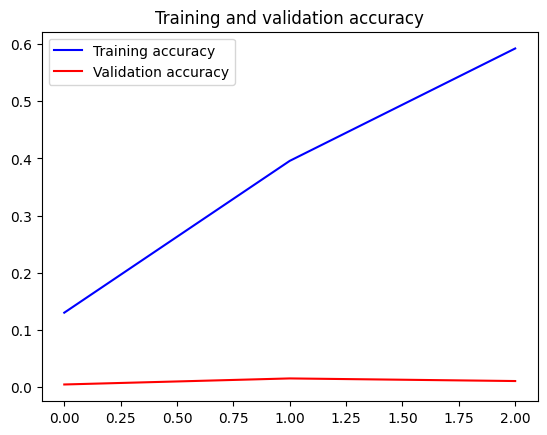

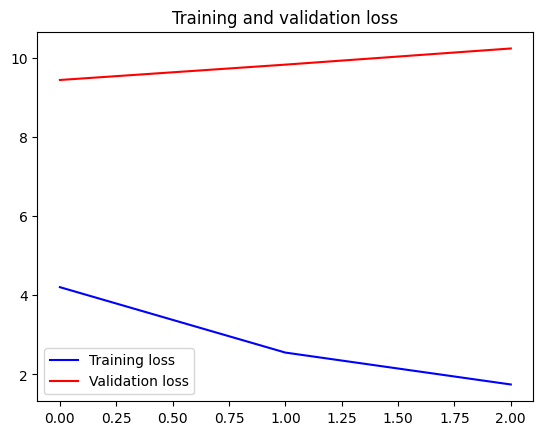

In [ ]:
# Plotting Loss and Accuracy vs Epoch
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

145/145 [==============================] - 19s 123ms/step
The first 5 predictions: ['kajol', 'Lindsey Morgan', 'Hrithik Roshan', 'Konkona Sen Sharma', 'Hrithik Roshan']


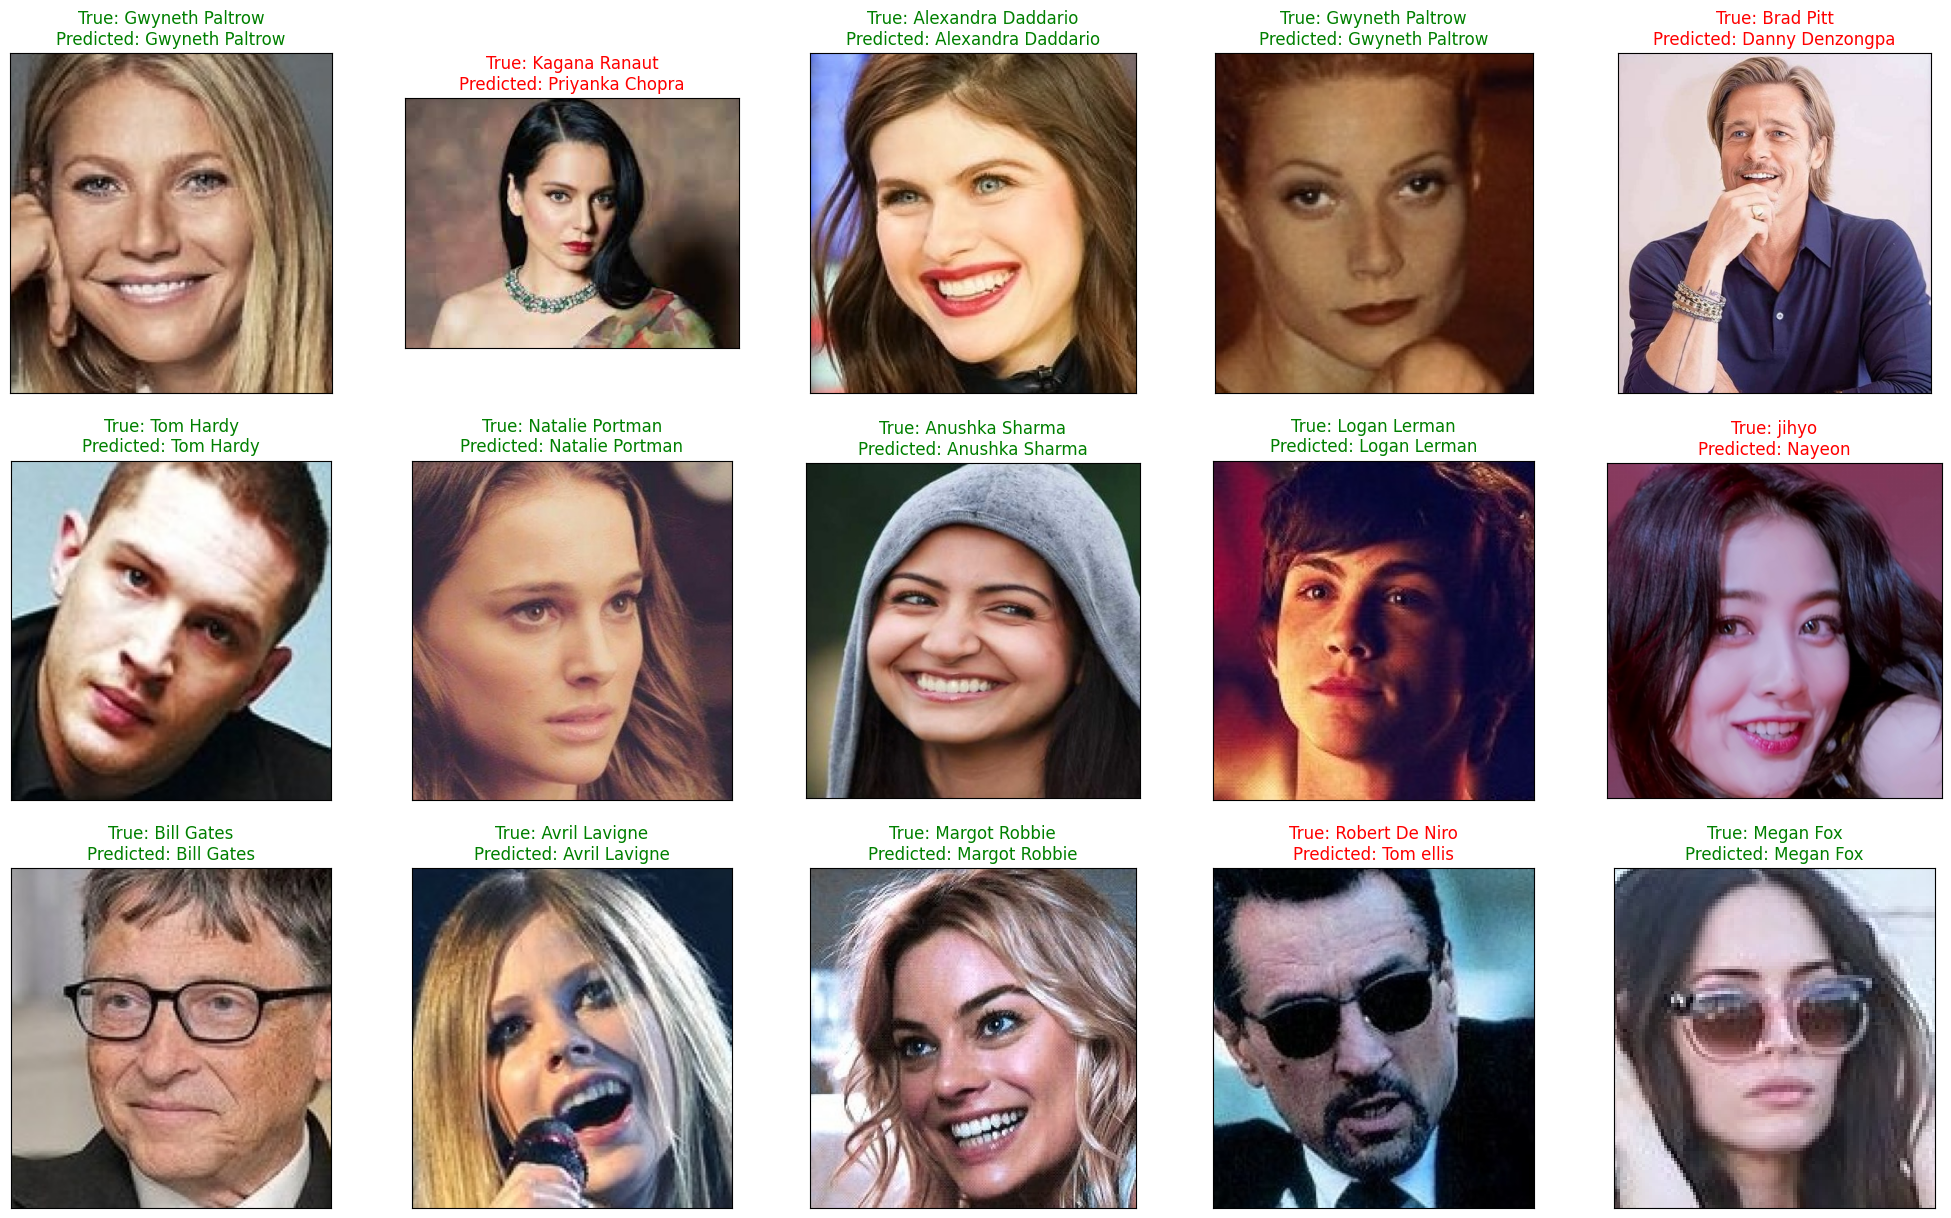

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 25 random pictures from the dataset with their labels

random_index = np.random.randint(0, len(test_dataset_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_dataset_df.Filepath_test.iloc[random_index[i]]))
    if test_dataset_df.Labels_test.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_dataset_df.Labels_test.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

#### Saving the best model for further prediction

In [ ]:
%%time
#Loading the best saved model to predict
K.clear_session()
model_best = load_model('best_model_inception.hdf5',compile=False)

CPU times: user 2.65 s, sys: 98.4 ms, total: 2.74 s
Wall time: 2.71 s


#### Predicting classes for new unseen images using the best trained model

In [ ]:
dir = "/content/drive/MyDrive/Colab Notebooks/train_data/train"
names_sorted = sorted(os.listdir(dir))
names_sorted = names_sorted[1:]
print(names_sorted)

['Adriana Lima', 'Akshay Kumar', 'Alex Lawther', 'Alexandra Daddario', 'Alia Bhatt', 'Alvaro Morte', 'Alycia dabnem carey', 'Amanda Crew', 'Amber heard', 'Andy Samberg', 'Angelina Jolie', 'Anne Hathaway', 'Anthony Mackie', 'Anushka Sharma', 'Anushka Shetty', 'Avril Lavigne', 'Ayushmann Khurrana', 'Barack obama', 'Barbara palvin', 'Ben Affleck', 'Bill Gates', 'Brad Pitt', 'Brenton Thwaites', 'Brie Larson', 'Camila mendes', 'Chris Evans', 'Chris Hemsworth', 'Chris Pratt', 'Christian Bale', 'Cristiano Ronaldo', 'Dahyun', 'Danielle Panabaker', 'Danny Denzongpa', 'Darsheel Safary', 'Deepika Padukone', 'Denzel Washington', 'Dominic Purcell', 'Dwayne Johnson', 'Elizabeth Lail', 'Elizabeth olsen', 'Elliot page', 'Elon musk', 'Emilia Clarke', 'Emma Stone', 'Emma Watson', 'Farhan Akhtar', 'Gal gadot', 'Grant gustin', 'Gwyneth Paltrow', 'Henry Cavil', 'Hrithik Roshan', 'Hugh Jackman', 'IU', 'Inbar Lavi', 'Irina Shayk', 'Irrfan Khan', 'Jake Mcdorman', 'Jason Momoa', 'Jeff bezos', 'Jennifer Lawrenc

In [ ]:
# Helper Function to predict

def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.

    pred = model.predict(img)
    index = np.argmax(pred)
    names_sorted.sort()
    pred_value = names_sorted[index]
    if show:
        plt.imshow(img[0])
        plt.axis('off')
        plt.title(pred_value)
        plt.show()


In [ ]:
# Downloading images from internet

!wget -O one.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/4/4e/Priyanka_Chopra_%2830688260090%29_%28cropped%29.jpg/640px-Priyanka_Chopra_%2830688260090%29_%28cropped%29.jpg
!wget -O two.jpg  https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Sophie_Turner_Deauville_2019.jpg/640px-Sophie_Turner_Deauville_2019.jpg
!wget -O three.jpg   https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/Kartik_Aaryan_in_2014.jpg/640px-Kartik_Aaryan_in_2014.jpg
!wget -O four.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/f/f1/170529_Suga_at_a_press_conference_for_he_BBMAs_%283%29.png/640px-170529_Suga_at_a_press_conference_for_he_BBMAs_%283%29.png
!wget -O five.jpg  https://upload.wikimedia.org/wikipedia/commons/thumb/f/f7/Anushka_Sharma_promotes_%27Ladies_vs_Ricky_Bahl%27_%282%29.jpg/640px-Anushka_Sharma_promotes_%27Ladies_vs_Ricky_Bahl%27_%282%29.jpg
!wget -O six.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Alexandra_daddario_2022_%28cropped%29.jpg/640px-Alexandra_daddario_2022_%28cropped%29.jpg


In [ ]:
images = []
images.append('one.jpg')
images.append('two.jpg')
images.append('three.jpg')
images.append('four.jpg')
images.append('five.jpg')
images.append('six.jpg')

In [ ]:
# model.summary()

1/1 [==============================] - 0s 29ms/step


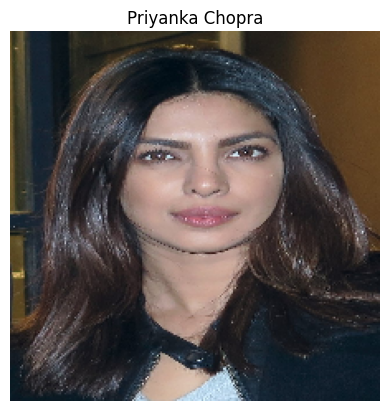

1/1 [==============================] - 0s 36ms/step


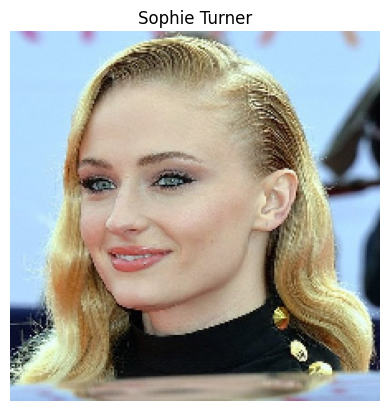

1/1 [==============================] - 0s 27ms/step


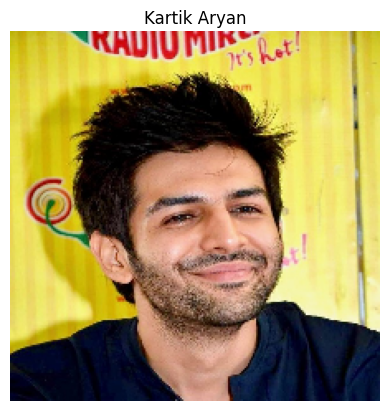

1/1 [==============================] - 0s 26ms/step


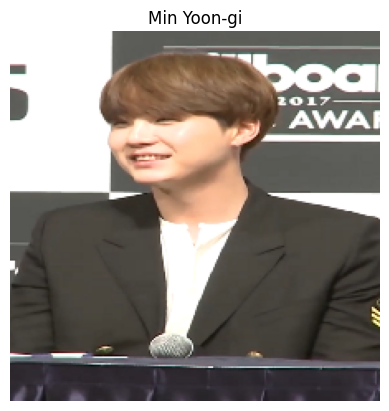

1/1 [==============================] - 0s 27ms/step


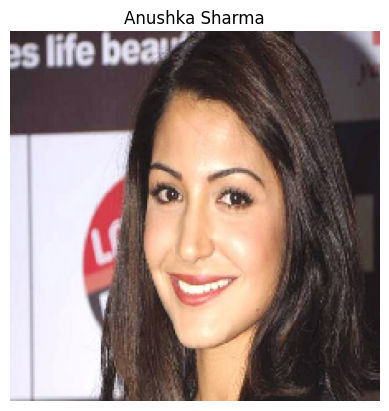

1/1 [==============================] - 0s 29ms/step


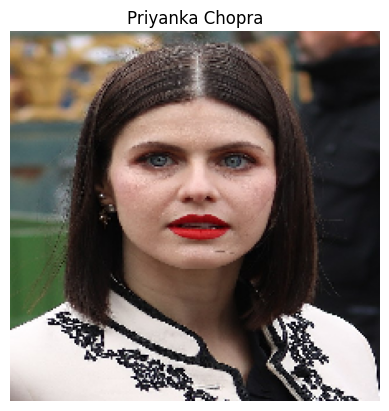

In [ ]:
# PREDICTION ON UNSEEN IMAGES

from tensorflow.keras.preprocessing import image

predict_class(model_best, images, True)

# Data Preprocessing.
1. Removing labels with less images
2. adding mores images to Train Dataset
